# __Import packages__

In [1]:
import pandas as pd
import numpy as np
import roman

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# __Ignore Future Warning__

In [2]:
# Ignore future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# __Load the Excel File__

In [3]:
# Load the Excel file
data = pd.read_excel('output.xlsx')

# __Shape of the data__

In [4]:
data.shape

(9568, 21)

# __Describe the data__

In [5]:
data.describe()

,Rating,Votes,Runtime,Gross (in million $),End_Year,Start_Year
count,9568.000000,9.568000e+03,9568.000000,9568.000000,1371.000000,8933.000000
mean,5.907201,1.292847e+04,50.446279,2.101051,2016.904449,2016.125378
std,2.692988,6.498853e+04,50.664321,20.331111,5.262488,7.387275
min,0.000000,0.000000e+00,0.000000,0.000000,1969.000000,1932.000000
25%,5.500000,6.400000e+01,0.000000,0.000000,2014.000000,2015.000000
50%,6.800000,4.895000e+02,43.000000,0.000000,2019.000000,2018.000000
75%,7.600000,2.903000e+03,87.000000,0.000000,2020.000000,2020.000000
max,9.900000,1.713028e+06,853.000000,504.010000,2022.000000,2023.000000


# __Datatypes__

In [6]:
data.dtypes

Movies                   object
Rating                  float64
Votes                     int64
Runtime                   int64
Gross (in million $)    float64
End_Year                float64
Start_Year              float64
Season                   object
Type                     object
Genre1                   object
Genre2                   object
Genre3                   object
Actor1                   object
Actor2                   object
Actor3                   object
Actor4                   object
Director1                object
Director2                object
Director3                object
Director4                object
One-Line-Summary         object
dtype: object

# __NULL count before data processing__

In [7]:
# Check for missing values before preprocessing
print("NULL count before preprocessing:-")
print(data.isnull().sum())

NULL count before preprocessing:-
Movies                     0
Rating                     0
Votes                      0
Runtime                    0
Gross (in million $)       0
End_Year                8197
Start_Year               635
Season                  9210
Type                    8608
Genre1                    78
Genre2                  2614
Genre3                  4748
Actor1                     0
Actor2                  1203
Actor3                  1443
Actor4                  1619
Director1                  0
Director2               8662
Director3               9410
Director4               9505
One-Line-Summary           0
dtype: int64


# __Strip data of unwanted space__

In [8]:
data['Season'] = data['Season'].str.strip()

data['Type'] = data['Type'].str.strip()

data['Genre1'] = data['Genre1'].str.strip()
data['Genre2'] = data['Genre2'].str.strip()
data['Genre3'] = data['Genre3'].str.strip()

data['Actor1'] = data['Actor1'].str.strip()
data['Actor2'] = data['Actor2'].str.strip()
data['Actor3'] = data['Actor3'].str.strip()
data['Actor4'] = data['Actor4'].str.strip()

data['Director1'] = data['Director1'].str.strip()
data['Director2'] = data['Director2'].str.strip()
data['Director3'] = data['Director3'].str.strip()
data['Director4'] = data['Director4'].str.strip()

# __Fill the missing values__

## __Replace empty string with NaN__

In [9]:
# Replace empty strings with NaN in the 'Type' column
data['Type'] = data['Type'].replace('', np.nan).str.strip()

data['Season'] = data['Season'].replace('', np.nan).str.strip()

data['Genre1'] = data['Genre1'].replace('', np.nan).str.strip()
data['Genre2'] = data['Genre2'].replace('', np.nan).str.strip()
data['Genre3'] = data['Genre3'].replace('', np.nan).str.strip()

data['Actor1'] = data['Actor1'].replace('', np.nan).str.strip()
data['Actor2'] = data['Actor2'].replace('', np.nan).str.strip()
data['Actor3'] = data['Actor2'].replace('', np.nan).str.strip()
data['Actor4'] = data['Actor3'].replace('', np.nan).str.strip()

data['Director1'] = data['Director1'].replace('', np.nan).str.strip()
data['Director2'] = data['Director2'].replace('', np.nan).str.strip()
data['Director3'] = data['Director3'].replace('', np.nan).str.strip()
data['Director4'] = data['Director4'].replace('', np.nan).str.strip()

## __When End Year is NULL and Type is NULL, check Runtime and update Type as TV Short or TV Movie__

In [10]:
# Condition 1

max_runtime_tvshort = data[data['Type'] == 'TV Short']['Runtime'].max()

cond1 = data['End_Year'].isna() & data['Type'].isna() & (data['Runtime']<=max_runtime_tvshort)
data.loc[cond1, 'Type'] = 'TV Short'

In [11]:
# Condition 2
cond2 = data['End_Year'].isna() & data['Type'].isna() & (data['Runtime']>max_runtime_tvshort)
data.loc[cond2, 'Type'] = 'TV Movie'

## __When End Year is not NULL and End Year != Start Year, update type as TV Series and Season as the roman numerical for (End Year - Start Year__)

In [12]:
# Condition 3

cond3 = (~data['End_Year'].isna()) & data['Season'].isna() & (data['End_Year'] != data['Start_Year']) & data['Type'].isna()
data.loc[cond3, 'Type'] = 'TV Series'
data.loc[cond3, 'Season'] = data['End_Year'] - data['Start_Year'] + 1

# Convert Season to Roman numerals
data['Season'] = data['Season'].apply(lambda x: roman.toRoman(int(x)) if pd.notna(x) and isinstance(x, (int, float)) else x)

## __Season is not NULL but Type is, update Type as 'TV Series'__

In [13]:
# Condition 4
cond4 = (~data['Season'].isna()) & (~data['End_Year'].isna()) & data['Type'].isna()
data.loc[cond4, 'Type'] = 'TV Series'

## __Use fillna() to fill the remaining NULL values__

In [14]:
# Fill missing values
data['Type'] = data['Type'].fillna('Unknown')  # or data.fillna(method='ffill')

In [15]:
data['Start_Year'] = data['Start_Year'].fillna(1).astype(int)
# Convert the 'Start Year' column to strings with leading zeros
data['Start_Year'] = data['Start_Year'].apply(lambda x: f"{x:04d}")
# data['End_Year'] = data['End_Year'].fillna(9999)

In [16]:
data['Genre1'] = data['Genre1'].fillna('Unknown')
data['Genre2'] = data['Genre2'].fillna('Unknown')
data['Genre3'] = data['Genre3'].fillna('Unknown')

In [17]:
data['Actor1'] = data['Actor1'].fillna('Unknown')
data['Actor2'] = data['Actor2'].fillna('Unknown')
data['Actor3'] = data['Actor3'].fillna('Unknown')
data['Actor4'] = data['Actor4'].fillna('Unknown')

In [18]:
data['Director1'] = data['Director1'].fillna('Unknown')
data['Director2'] = data['Director2'].fillna('Unknown')
data['Director3'] = data['Director3'].fillna('Unknown')
data['Director4'] = data['Director4'].fillna('Unknown')

In [19]:
data['Season'] = data['Season'].fillna("No Info Provided")

In [20]:
# Update gross value 0 with the mean gross value
mean_gross = data['Gross (in million $)'].mean().round(2)
data.loc[data['Gross (in million $)'] == 0, 'Gross (in million $)'] = mean_gross

# __NULL count after data processing__

In [21]:
# Check for missing values before preprocessing
print("NULL count before preprocessing:-")
print(data.isnull().sum())

NULL count before preprocessing:-
Movies                     0
Rating                     0
Votes                      0
Runtime                    0
Gross (in million $)       0
End_Year                8197
Start_Year                 0
Season                     0
Type                       0
Genre1                     0
Genre2                     0
Genre3                     0
Actor1                     0
Actor2                     0
Actor3                     0
Actor4                     0
Director1                  0
Director2                  0
Director3                  0
Director4                  0
One-Line-Summary           0
dtype: int64


# __Write the updated output__

In [22]:
data.to_excel('output_updated.xlsx', index=False)

# __Copy the required columns__

In [23]:
data_selected = data[['Rating', 'Votes', 'Runtime', 'Gross (in million $)', 'Type', 'Genre1', 'Genre2', 'Genre3']].copy()

In [24]:
data_selected.dtypes

Rating                  float64
Votes                     int64
Runtime                   int64
Gross (in million $)    float64
Type                     object
Genre1                   object
Genre2                   object
Genre3                   object
dtype: object

# __Find outliers__

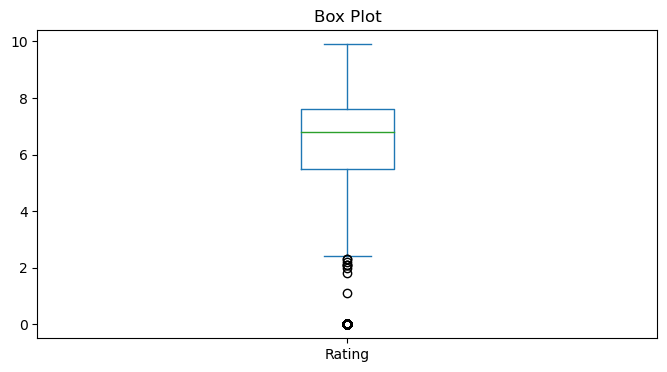

In [25]:
rating = data_selected['Rating']  # 100 is an outlier

# Creating a box plot
plt.figure(figsize=(8, 4))
rating.plot(kind='box')
plt.title('Box Plot')
plt.show()


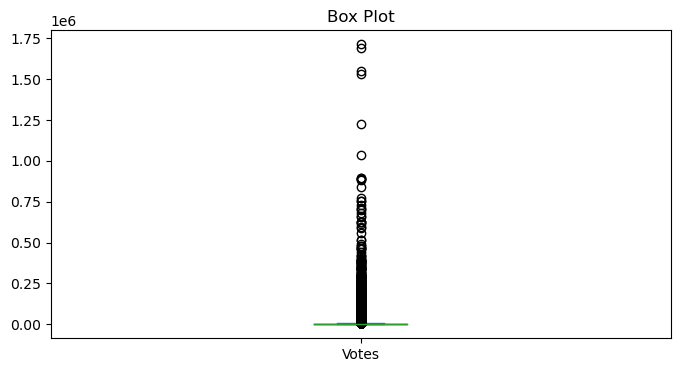

In [26]:
votes = data_selected['Votes']  # 100 is an outlier

# Creating a box plot
plt.figure(figsize=(8, 4))
votes.plot(kind='box')
plt.title('Box Plot')
plt.show()


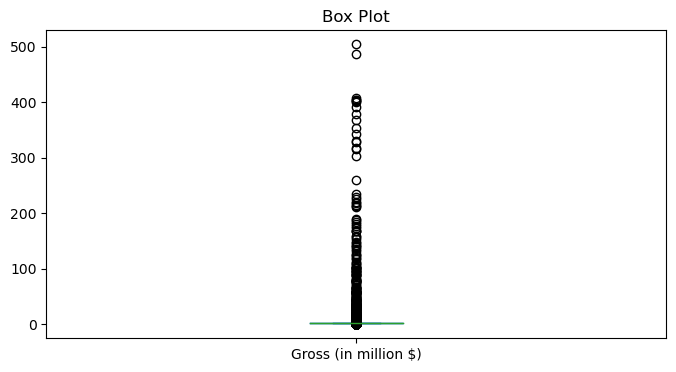

In [27]:
gross = data_selected['Gross (in million $)']

# Creating a box plot
plt.figure(figsize=(8, 4))
gross.plot(kind='box')
plt.title('Box Plot')
plt.show()


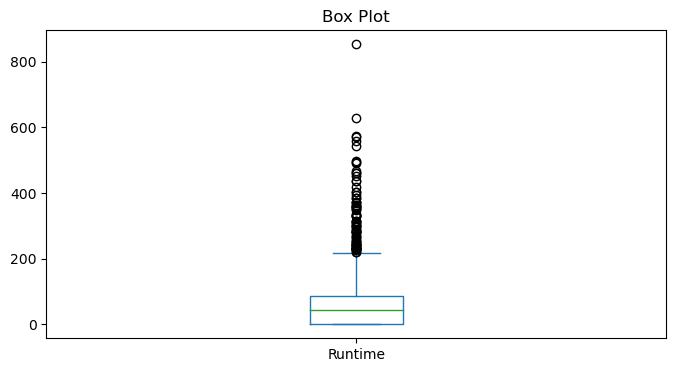

In [28]:
runtime = data_selected['Runtime']  # 100 is an outlier

# Creating a box plot
plt.figure(figsize=(8, 4))
runtime.plot(kind='box')
plt.title('Box Plot')
plt.show()


# __Standard Scalar__

In [29]:
# Select only numerical features for scaling
numerical_data = data_selected.select_dtypes(include=['int64', 'float64'])
scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(numerical_data)

# Replace the original numerical data with scaled data
for col in numerical_data.columns:
    data_selected[col] = scaled_numerical_data[:, numerical_data.columns.get_loc(col)]

print(data_selected)

        Rating     Votes   Runtime  Gross (in million $)       Type  \
0     1.482743 -0.008609 -0.482540             -0.099538  TV Series   
1     1.482743 -0.063329  0.820220             -0.099538  TV Series   
2     1.445607 -0.117649  0.820220             -0.099538  TV Series   
3     1.445607 -0.019858  0.010930             -0.099538  TV Series   
4     1.408472 -0.156320 -0.522017             -0.099538  TV Series   
...        ...       ...       ...                   ...        ...   
9563 -2.193664 -0.198945 -0.995748             -0.099538   TV Short   
9564 -2.193664 -0.198945 -0.995748             -0.099538   TV Short   
9565 -2.193664 -0.198945 -0.995748             -0.099538   TV Short   
9566 -2.193664 -0.198945 -0.995748             -0.099538   TV Short   
9567 -2.193664 -0.198945 -0.995748             -0.099538   TV Short   

           Genre1    Genre2     Genre3  
0       Animation    Comedy      Drama  
1       Animation    Action  Adventure  
2       Animation    Act

# __Convert catagorical data to numeric__

## __Genre__

In [30]:
# Convert categorical data to numeric if necessary
data_selected['Genre1_Cat'] = pd.Categorical(data_selected['Genre1'])
data_selected['Genre1_Cat'] = data_selected['Genre1_Cat'].cat.codes

data_selected['Genre2_Cat'] = pd.Categorical(data_selected['Genre2'])
data_selected['Genre2_Cat'] = data_selected['Genre2_Cat'].cat.codes

data_selected['Genre3_Cat'] = pd.Categorical(data_selected['Genre3'])
data_selected['Genre3_Cat'] = data_selected['Genre3_Cat'].cat.codes
data_selected.head()

,Rating,Votes,Runtime,Gross (in million $),Type,Genre1,Genre2,Genre3,Genre1_Cat,Genre2_Cat,Genre3_Cat
0,1.482743,-0.008609,-0.482540,-0.099538,TV Series,Animation,Comedy,Drama,2,4,5
1,1.482743,-0.063329,0.820220,-0.099538,TV Series,Animation,Action,Adventure,2,0,1
2,1.445607,-0.117649,0.820220,-0.099538,TV Series,Animation,Action,Adventure,2,0,1
3,1.445607,-0.019858,0.010930,-0.099538,TV Series,Crime,Drama,Mystery,5,7,14
4,1.408472,-0.156320,-0.522017,-0.099538,TV Series,Animation,Action,Adventure,2,0,1


## __Type__

In [31]:
data_selected['Type_Cat'] = pd.Categorical(data_selected['Type'])
data_selected['Type_Cat'] = data_selected['Type_Cat'].cat.codes

# __Drop the unwanted columns__

In [32]:
data_selected.drop(['Genre1', 'Genre2', 'Genre3', 'Type'], axis=1, inplace=True)
data_selected.head(5)

,Rating,Votes,Runtime,Gross (in million $),Genre1_Cat,Genre2_Cat,Genre3_Cat,Type_Cat
0,1.482743,-0.008609,-0.482540,-0.099538,2,4,5,1
1,1.482743,-0.063329,0.820220,-0.099538,2,0,1,1
2,1.445607,-0.117649,0.820220,-0.099538,2,0,1,1
3,1.445607,-0.019858,0.010930,-0.099538,5,7,14,1
4,1.408472,-0.156320,-0.522017,-0.099538,2,0,1,1


# __Elbow Method__

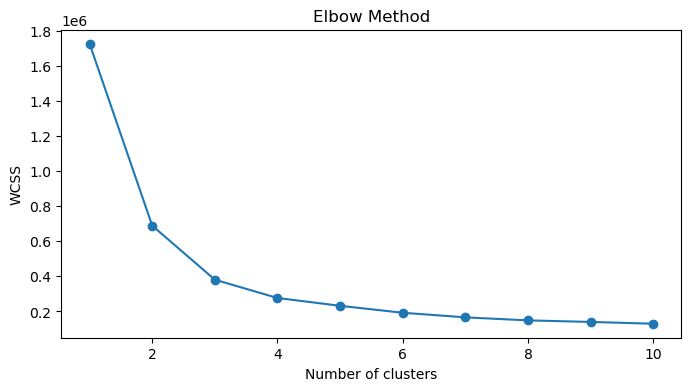

In [33]:
# Calculating WCSS for different values of k
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(data_selected)
    wcss.append(kmeans.inertia_)  # Inertia: Sum of distances of samples to their closest cluster center

# Plotting the results
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

__Since, the WCSS starts of levelling after cluster number 4, the clustering is going to be performed using the value 4.__

# __K-Means Clustering__

In [34]:
# Applying K-means
kmeans = KMeans(n_clusters=4, random_state=42)

## __Genre1, Genre2__

Silhouette Score:  0.5649516835727125
Calinski-Harabasz Score:  25748.512989095285
Davies-Bouldin Score:  0.6493809537261521


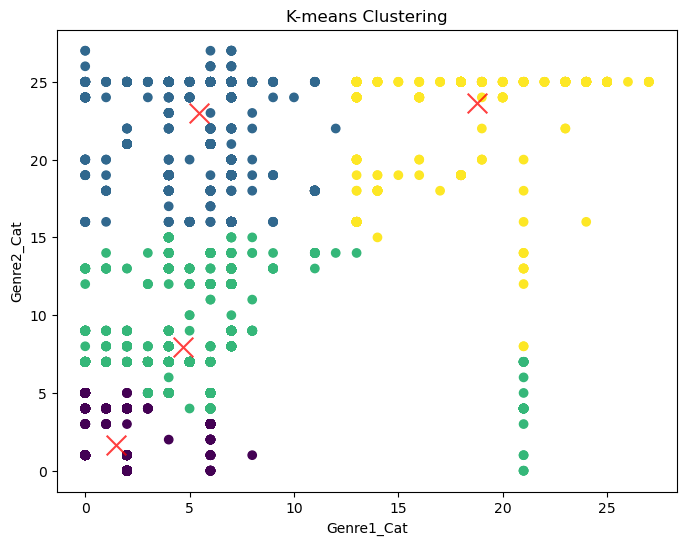

In [35]:
features = data_selected[['Genre1_Cat', 'Genre2_Cat']]
data_selected['Cluster'] = kmeans.fit_predict(features)

# Scores
s_score = silhouette_score(features, data_selected['Cluster'])
print("Silhouette Score: ", s_score) #Should be closer to 1. 0.5 to 0.7 = good clustering, >0.7 = Strong clustering
ch_score = calinski_harabasz_score(features, data_selected['Cluster'])
print("Calinski-Harabasz Score: ", ch_score) #Higher is better
db_score = davies_bouldin_score(features, data_selected['Cluster'])
print("Davies-Bouldin Score: ", db_score) #Lower is better

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(data_selected['Genre1_Cat'], data_selected['Genre2_Cat'], c=data_selected['Cluster'], cmap='viridis', marker='o')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')
plt.title('K-means Clustering')
plt.xlabel('Genre1_Cat')
plt.ylabel('Genre2_Cat')
plt.show()

## __Genre1, Genre2, Genre3__

Silhouette Score:  0.5616576464245091
Calinski-Harabasz Score:  30617.46345204267
Davies-Bouldin Score:  0.6554859629410501


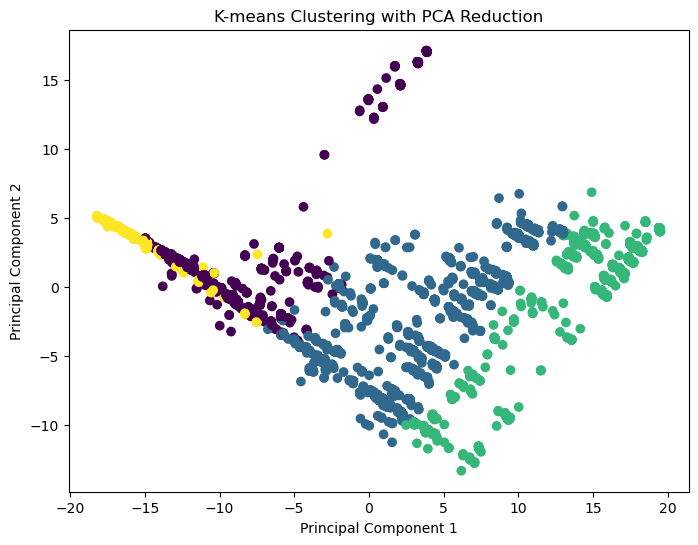

In [36]:
features = data_selected[['Genre1_Cat', 'Genre2_Cat', 'Genre2_Cat']]
data_selected['Cluster'] = kmeans.fit_predict(features)

# Scores
s_score = silhouette_score(features, data_selected['Cluster'])
print("Silhouette Score: ", s_score) #Should be closer to 1. 0.5 to 0.7 = good clustering, >0.7 = Strong clustering
ch_score = calinski_harabasz_score(features, data_selected['Cluster'])
print("Calinski-Harabasz Score: ", ch_score) #Higher is better
db_score = davies_bouldin_score(features, data_selected['Cluster'])
print("Davies-Bouldin Score: ", db_score) #Lower is better

# PCA for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data_selected.drop('Cluster', axis=1))
reduced_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

# Add back the cluster labels
reduced_df['Cluster'] = data_selected['Cluster']

# Plotting the reduced data
plt.figure(figsize=(8, 6))
plt.scatter(reduced_df['PC1'], reduced_df['PC2'], c=reduced_df['Cluster'], cmap='viridis', marker='o')
plt.title('K-means Clustering with PCA Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## __Rating, Votes__

Silhouette Score:  0.7783747164440008
Calinski-Harabasz Score:  15618.411241709091
Davies-Bouldin Score:  0.44653322344976343


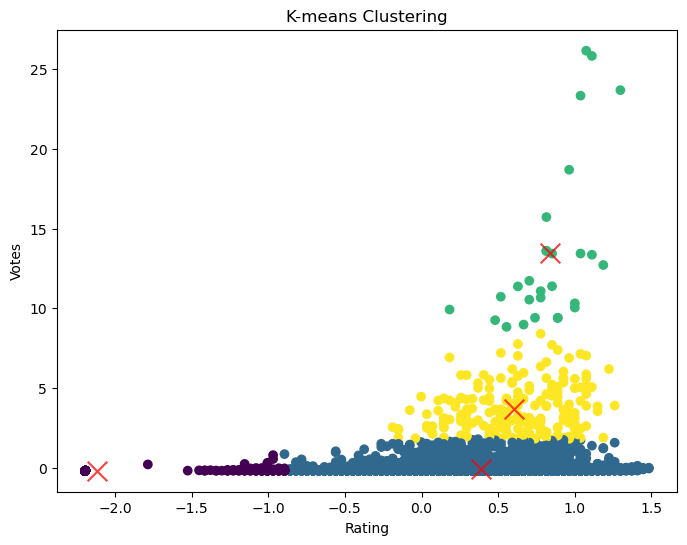

In [37]:
features = data_selected[['Rating', 'Votes']]
data_selected['Cluster'] = kmeans.fit_predict(features)

# Scores
s_score = silhouette_score(features, data_selected['Cluster'])
print("Silhouette Score: ", s_score) #Should be closer to 1. 0.5 to 0.7 = good clustering, >0.7 = Strong clustering
ch_score = calinski_harabasz_score(features, data_selected['Cluster'])
print("Calinski-Harabasz Score: ", ch_score) #Higher is better
db_score = davies_bouldin_score(features, data_selected['Cluster'])
print("Davies-Bouldin Score: ", db_score) #Lower is better

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(data_selected['Rating'], data_selected['Votes'], c=data_selected['Cluster'], cmap='viridis', marker='o')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')
plt.title('K-means Clustering')
plt.xlabel('Rating')
plt.ylabel('Votes')
plt.show()

## __Runtime, Gross (in million $)__

Silhouette Score:  0.6236255830779857
Calinski-Harabasz Score:  10237.045226285629
Davies-Bouldin Score:  0.5207352933455004


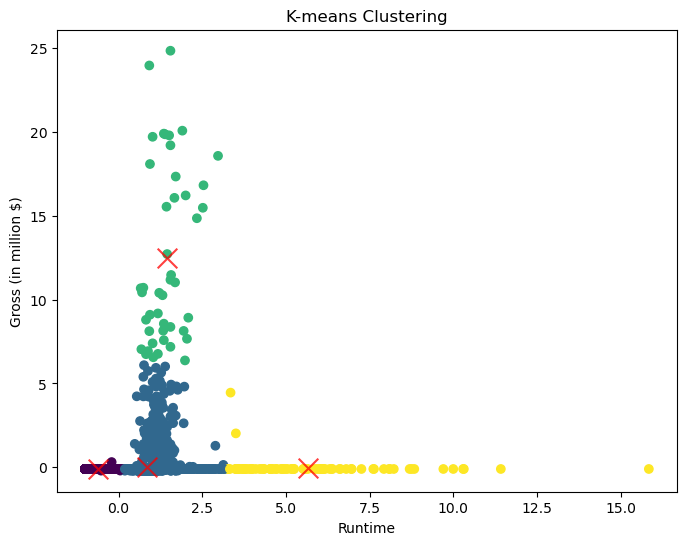

In [38]:
features = data_selected[['Runtime', 'Gross (in million $)']]
data_selected['Cluster'] = kmeans.fit_predict(features)

# Scores
s_score = silhouette_score(features, data_selected['Cluster'])
print("Silhouette Score: ", s_score) #Should be closer to 1. 0.5 to 0.7 = good clustering, >0.7 = Strong clustering
ch_score = calinski_harabasz_score(features, data_selected['Cluster'])
print("Calinski-Harabasz Score: ", ch_score) #Higher is better
db_score = davies_bouldin_score(features, data_selected['Cluster'])
print("Davies-Bouldin Score: ", db_score) #Lower is better

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(data_selected['Runtime'], data_selected['Gross (in million $)'], c=data_selected['Cluster'], cmap='viridis', marker='o')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')
plt.title('K-means Clustering')
plt.xlabel('Runtime')
plt.ylabel('Gross (in million $)')
plt.show()